# Energy Measurement Evaluation

This notebook evaluates power consumption and energy trends from experiment results.  
The data is collected from multiple nodes and analyzed for insights into power usage, voltage, and energy consumption.

## Specify the Result Folder

Before loading data, enter the path to your experiment result folder.  
By default, the last used path is shown, but you can change it to any valid directory.

In [7]:
import os
from IPython.display import display

# Default result folder (can be changed by user)
default_result_folder = "/srv/testbed/results/warmuth/default/2025-02-26_18-06-05_836417"

# Ask user for input with a default value
user_input = input(f"Enter result folder path [{default_result_folder}]: ").strip()
RESULT_FOLDER = user_input if user_input else default_result_folder

# Check if the folder exists
if not os.path.exists(RESULT_FOLDER):
    raise FileNotFoundError(f"Result folder not found: {RESULT_FOLDER}")

display(f"Using result folder: {RESULT_FOLDER}")

'Using result folder: /srv/testbed/results/warmuth/default/2025-02-26_18-06-05_836417'

## Node Information & Topology Visualization

Each experiment setup includes metadata about the participating nodes.  
This section extracts details such as:
- Node names
- Fully Qualified Domain Names (FQDN)
- Topology information (if available).

If a **topology visualization** is provided in the RO-Crate metadata, it is displayed below.

In [14]:
import json
import pandas as pd
import os
from IPython.display import display, Markdown, HTML

def load_rocrate_metadata():
    """
    Load and parse the RO-Crate metadata JSON file.
    Extract node information and locate paths for hardware details and topology PDFs.
    """
    rocrate_path = os.path.join(RESULT_FOLDER, "ro-crate-metadata.json")
    if not os.path.exists(rocrate_path):
        raise FileNotFoundError(f"RO-Crate metadata file not found: {rocrate_path}")

    with open(rocrate_path, "r") as f:
        metadata = json.load(f)

    nodes_info = []

    for item in metadata.get("@graph", []):
        if "keywords" in item and "node" in item["keywords"]:
            node_name = item.get("name", "Unknown")
            fqdn = item.get("fqdn", "Unknown")

            # Check for visualized topology PDF
            topology_pdf_path = None
            if isinstance(item.get("visualizedTopology", {}), dict) and "@id" in item["visualizedTopology"]:
                topology_pdf_path = os.path.join(RESULT_FOLDER, item["visualizedTopology"]["@id"])
                if not os.path.exists(topology_pdf_path):
                    topology_pdf_path = None  # Ignore missing PDFs

            # Check for hardware information JSON
            hardware_json_path = None
            if isinstance(item.get("hardware", {}), dict) and "@id" in item["hardware"]:
                hardware_json_path = os.path.join(RESULT_FOLDER, item["hardware"]["@id"])
                if not os.path.exists(hardware_json_path):
                    hardware_json_path = None  # Ignore missing hardware files

            nodes_info.append({
                "name": node_name if isinstance(node_name, str) else "Unknown",
                "fqdn": fqdn if isinstance(fqdn, str) else "Unknown",
                "topology_pdf": topology_pdf_path if topology_pdf_path else "None",
                "hardware_json": hardware_json_path if hardware_json_path else "None"
            })

    return nodes_info

def extract_hardware_info(hardware_json_path):
    """
    Extract processor, network, and memory information from the hardware.json file.
    Returns a dictionary with processor details, NIC models, and installed memory.
    """
    if not hardware_json_path or not os.path.exists(hardware_json_path):
        return {
            "cpu_model": "Unknown", "cpu_cores": "Unknown", "cpu_threads": "Unknown",
            "memory": "Unknown", "nic_models": "Unknown"
        }

    try:
        with open(hardware_json_path, "r") as f:
            hardware_data = json.load(f)

        # Extract processor information
        cpu_data = hardware_data.get("processor", [{}])[0]
        cpu_model = cpu_data.get("model", "Unknown")
        cpu_cores = cpu_data.get("cores", "Unknown")
        cpu_threads = cpu_data.get("threads", "Unknown")

        # Extract NIC models
        nic_models = []
        if isinstance(hardware_data.get("network"), list):
            for nic in hardware_data["network"]:
                if isinstance(nic, dict) and "model" in nic:
                    nic_models.append(nic["model"])

        # Extract installed memory
        memory_val = hardware_data.get("memory", {}).get("installed_capacity_human_val", "Unknown")
        memory_unit = hardware_data.get("memory", {}).get("installed_capacity_human_unit", "")
        memory_str = f"{memory_val} {memory_unit}" if isinstance(memory_val, (int, float, str)) else "Unknown"

        return {
            "cpu_model": cpu_model if isinstance(cpu_model, str) else "Unknown",
            "cpu_cores": cpu_cores if isinstance(cpu_cores, int) else "Unknown",
            "cpu_threads": cpu_threads if isinstance(cpu_threads, int) else "Unknown",
            "memory": f"RAM: {memory_str}" if memory_str != "Unknown" else "Unknown",
            "nic_models": "<br>".join(nic_models) if nic_models else "No NICs detected",
        }

    except (json.JSONDecodeError, KeyError, TypeError):
        return {
            "cpu_model": "Unknown", "cpu_cores": "Unknown", "cpu_threads": "Unknown",
            "memory": "Unknown", "nic_models": "Unknown"
        }

# Extract node metadata
nodes_info = load_rocrate_metadata()

# Convert to DataFrame
nodes_df = pd.DataFrame(nodes_info)

# Extract hardware details and merge into the DataFrame
hardware_details = [extract_hardware_info(node["hardware_json"]) for node in nodes_info]
hardware_df = pd.DataFrame(hardware_details)

# Merge hardware details with node info
nodes_df = pd.concat([nodes_df, hardware_df], axis=1)

# Remove "hardware_json" column (no longer needed)
nodes_df.drop(columns=["hardware_json"], inplace=True)

# Convert topology path to clickable links
def make_clickable(path):
    if path != "None":
        return f'<a href="{path}" target="_blank">Open PDF</a>'
    return "No topology available"

nodes_df["topology_pdf"] = nodes_df["topology_pdf"].apply(make_clickable)

# Rename columns for better readability
nodes_df.rename(columns={
    "name": "Name",
    "fqdn": "FQDN",
    "topology_pdf": "Topology",
    "cpu_model": "CPU",
    "cpu_cores": "Cores",
    "cpu_threads": "Threads",
    "memory": "Memory",
    "nic_models": "NICs"
}, inplace=True)

# Reorder columns for a more logical flow
nodes_df = nodes_df[["Name", "FQDN", "Topology", "CPU", "Cores", "Threads", "Memory", "NICs"]]

# Apply table styling for better readability
html_table = nodes_df.to_html(escape=False)
styled_table = f"""
<style>
    table {{ width: 90%; border-collapse: collapse; margin: 20px 0; }}
    th, td {{ padding: 8px 12px; border: 1px solid #ddd; text-align: left; }}
    th {{ background-color: #f4f4f4; font-weight: bold; }}
</style>
{html_table}
"""

# Display the formatted table
display(HTML(styled_table))

,Name,FQDN,Topology,CPU,Cores,Threads,Memory,NICs
0,Testbed Node riga,riga.baltikum.net.cit.tum.de,Open PDF,Xeon E31230 @ 3.20GHz,4,8,RAM: 16 GiB,82576 Gigabit82576 Gigabit82579LM Gigabit (Lewisville)82574L Gigabit
1,Testbed Node vilnius,vilnius.baltikum.net.cit.tum.de,Open PDF,Xeon E31230 @ 3.20GHz,4,8,RAM: 16 GiB,I350 Gigabit82579LM Gigabit (Lewisville)82574L Gigabit


## Loading and Previewing Data

The energy measurement data is stored in CSV format, with each node having its own folder inside the `energy` directory.

The dataset includes:
- **Timestamp** (`timestamp`): Time when the measurement was recorded.
- **Current** (`current_mA`): Measured current in milliamps (mA).
- **Voltage** (`voltage_V`): Measured voltage in volts (V).
- **Power Consumption** (`power_active_W`): Active power in watts (W).
- **Energy Counter** (`energy_counter_Wh`): Cumulative energy usage in watt-hours (Wh).

Below, we load the data and display a preview.

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import display

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams.update({"axes.titlesize": 14, "axes.labelsize": 12})

RESULT_FOLDER = "/srv/testbed/results/warmuth/default/2025-02-26_18-06-05_836417"

def load_energy_data():
    """
    Load all CSV files from the energy folder inside the result folder.
    Each node has its own subfolder containing multiple _runXX.csv files.
    """
    energy_folder = os.path.join(RESULT_FOLDER, "energy")
    if not os.path.exists(energy_folder):
        raise FileNotFoundError(f"Energy folder not found: {energy_folder}")

    all_data = []

    for node in os.listdir(energy_folder):
        node_path = os.path.join(energy_folder, node)
        if os.path.isdir(node_path):
            for file in os.listdir(node_path):
                if file.endswith(".csv") and "_run" in file:
                    file_path = os.path.join(node_path, file)
                    df = pd.read_csv(file_path)

                    # Convert timestamp for better readability
                    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y%m%d%H%M%S%f")

                    # Add metadata columns
                    df["node"] = node
                    df["run"] = file.split("_run")[-1].split(".")[0]  # Extract run number
                    all_data.append(df)

    if not all_data:
        raise ValueError("No valid CSV files found in the energy folder.")

    return pd.concat(all_data, ignore_index=True)

df = load_energy_data()

# Display Data Preview
display(df.head())

,timestamp,current_mA,voltage_V,power_active_W,energy_counter_Wh,node,run
0,2025-02-26 18:10:05.943973,318,232,59,14,riga,0
1,2025-02-26 18:10:06.938554,316,232,59,0,riga,0
2,2025-02-26 18:10:07.939856,316,232,59,0,riga,0
3,2025-02-26 18:10:08.939446,354,231,67,0,riga,0
4,2025-02-26 18:10:09.942393,374,231,73,0,riga,0


## Data Overview

After loading the data, we analyze its structure using summary statistics.  
This helps in identifying potential issues such as missing values, anomalies, or trends.

In [10]:
display(df.describe())

,timestamp,current_mA,voltage_V,power_active_W,energy_counter_Wh
count,254,254.000000,254.000000,254.000000,254.000000
mean,2025-02-26 18:11:11.413462784,378.374016,231.051181,74.795276,0.283465
min,2025-02-26 18:10:05.943973,274.000000,231.000000,49.000000,0.000000
25%,2025-02-26 18:10:37.317808640,320.000000,231.000000,61.000000,0.000000
50%,2025-02-26 18:11:11.662528512,320.000000,231.000000,61.000000,0.000000
75%,2025-02-26 18:11:45.308602880,458.000000,231.000000,94.000000,0.000000
max,2025-02-26 18:12:17.364367,475.000000,232.000000,98.000000,14.000000
std,NaN,71.235385,0.220802,17.155802,1.130935


## Power Consumption Over Time

The following plot shows the power consumption trends over time for different nodes.  
This helps us observe variations in power usage and detect potential anomalies.

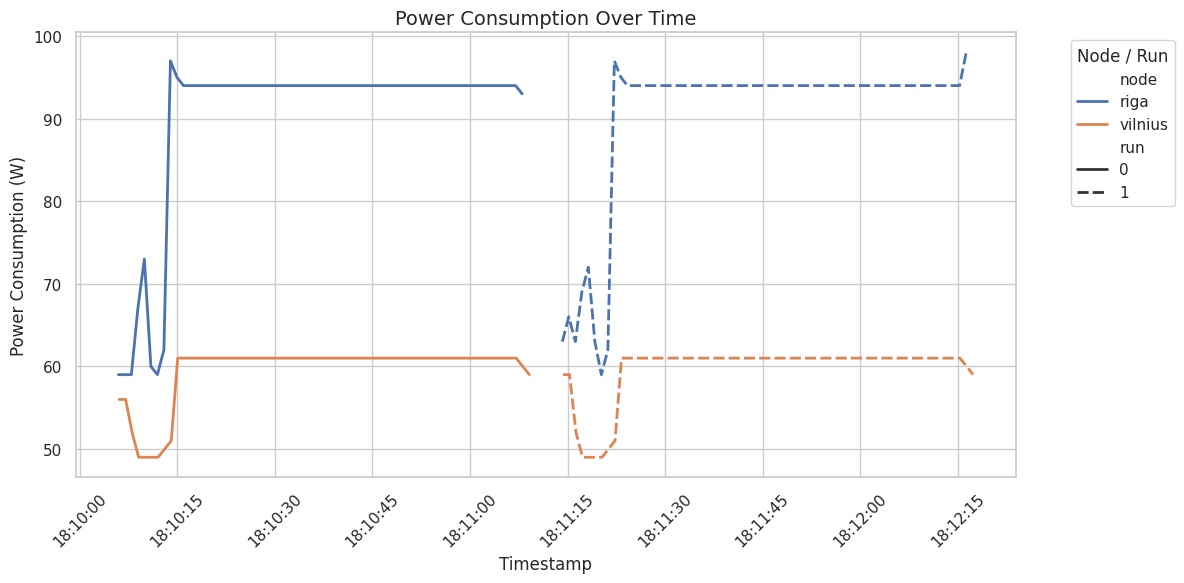

In [11]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="timestamp", y="power_active_W", hue="node", style="run", linewidth=2)
plt.xlabel("Timestamp")
plt.ylabel("Power Consumption (W)")
plt.title("Power Consumption Over Time")
plt.xticks(rotation=45)
plt.legend(title="Node / Run", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Cumulative Energy Consumption

The energy counter represents the cumulative energy consumed over time.  
This plot provides insights into the total energy usage per node and how it changes over the experiment duration.

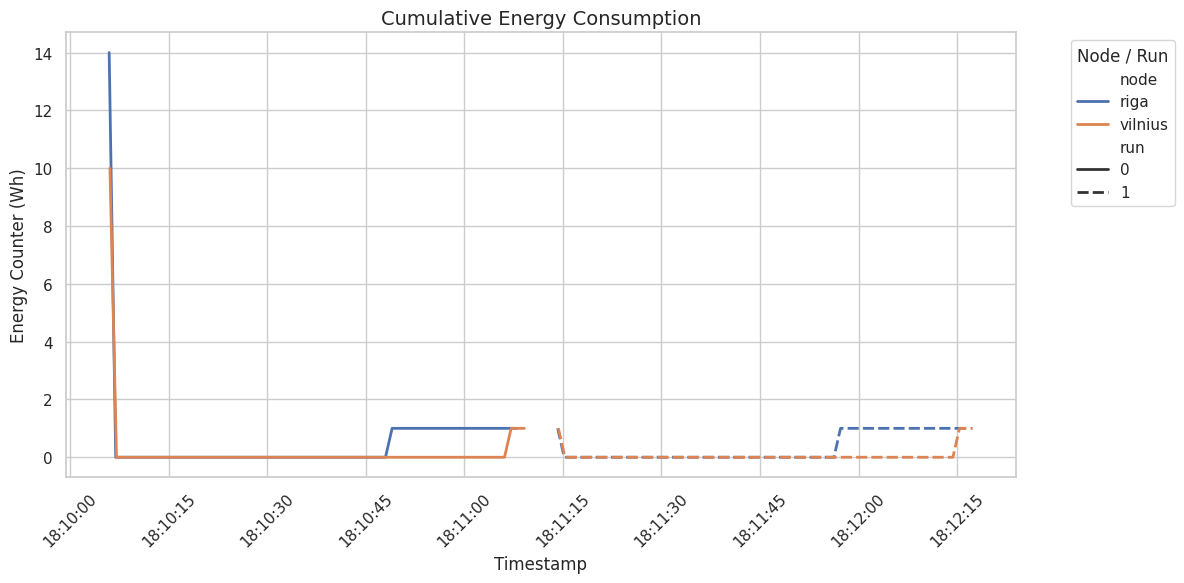

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="timestamp", y="energy_counter_Wh", hue="node", style="run", linewidth=2)
plt.xlabel("Timestamp")
plt.ylabel("Energy Counter (Wh)")
plt.title("Cumulative Energy Consumption")
plt.xticks(rotation=45)
plt.legend(title="Node / Run", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Current and Voltage Trends

To better understand the electrical characteristics, we visualize:
- **Current (mA) over time** to see how power draw fluctuates.
- **Voltage (V) over time** to ensure stability across measurements.

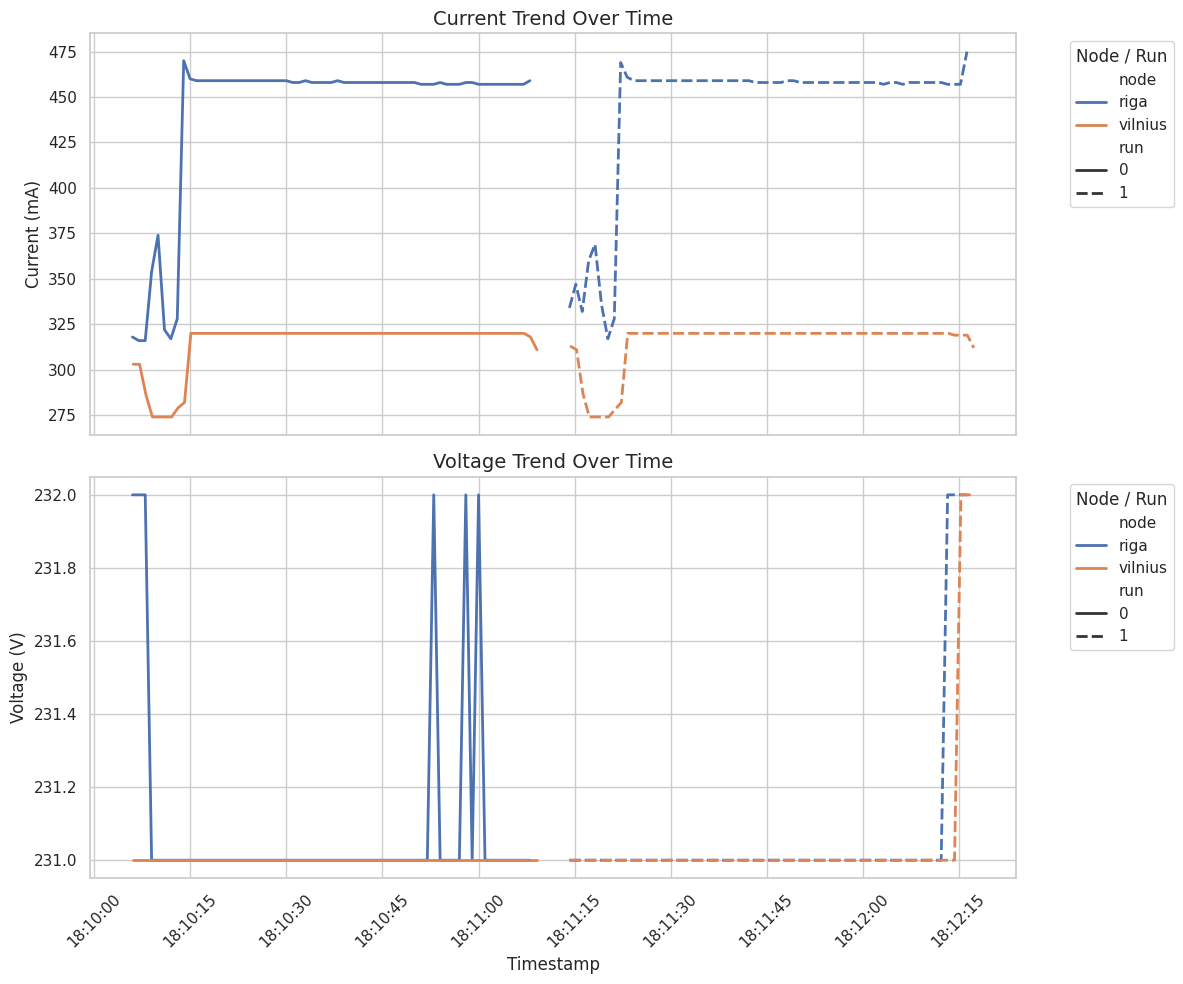

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

sns.lineplot(data=df, x="timestamp", y="current_mA", hue="node", style="run", linewidth=2, ax=axes[0])
axes[0].set_ylabel("Current (mA)")
axes[0].set_title("Current Trend Over Time")
axes[0].legend(title="Node / Run", bbox_to_anchor=(1.05, 1), loc='upper left')

sns.lineplot(data=df, x="timestamp", y="voltage_V", hue="node", style="run", linewidth=2, ax=axes[1])
axes[1].set_ylabel("Voltage (V)")
axes[1].set_title("Voltage Trend Over Time")
axes[1].set_xlabel("Timestamp")
axes[1].legend(title="Node / Run", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Summary & Findings

Based on the visualizations and statistical analysis, we can derive the following insights:

- The power consumption varies across different nodes and runs.
- The cumulative energy consumption follows an increasing trend over time.
- Voltage and current appear stable with minor fluctuations.

Further analysis could involve:
- Identifying periods of peak energy usage.
- Comparing nodes to find efficiency variations.
- Investigating external factors influencing power consumption.

This concludes the evaluation of energy measurements.